In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning
import warnings

import streamlit as st

warnings.filterwarnings('ignore')
df = pd.read_csv('merged_dataset2.csv')

In [2]:
df

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,MTRANS,Class,Weight,CALC,NObeyesdad,BMI,class
0,1,14,171,1,1,3,3,2,2,3,2,2,2,5,NaN,72.000000,0,Normal_Weight,24.622961,Normal
1,1,16,167,1,1,2,1,3,2,3,2,1,1,4,NaN,50.000000,0,Insufficient_Weight,17.928215,Underweight
2,1,16,169,2,1,2,1,2,2,2,2,0,0,4,NaN,50.000000,1,Insufficient_Weight,17.481431,Underweight
3,1,16,169,2,1,2,2,2,2,2,2,0,0,4,NaN,52.629374,1,Insufficient_Weight,18.405067,Underweight
4,1,16,175,2,1,2,3,2,2,1,2,1,1,4,NaN,50.000000,1,Insufficient_Weight,16.275246,Underweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,2,54,169,2,2,2,1,2,2,2,1,2,0,1,Overweight,78.399945,NaN,NaN,NaN,NaN
3717,2,54,170,1,1,1,3,4,1,3,2,2,0,1,Obesity,93.925000,NaN,NaN,NaN,NaN
3718,2,54,174,2,1,1,3,3,2,2,1,2,0,1,Overweight,83.107620,NaN,NaN,NaN,NaN
3719,2,54,175,2,1,1,3,3,2,3,1,2,0,1,Overweight,84.065625,NaN,NaN,NaN,NaN


In [3]:
X = df[['Weight', 'Height', 'family_history_with_overweight', 'FAF', 'FCVC', 'TUE']]
y = df['BMI']  

# NaN 값이 있는 행 제거
X = X[~y.isna()]
y = y.dropna()

# 데이터 분할
#train_test_split을 이용하여 데이터를 학습 및 테스트 세트로 분할하고, StandardScaler를 이용해 데이터를 표준화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu',           
    solver='adam',                
    alpha=0.0001,                 
    learning_rate_init=0.001,   
    max_iter=200             
)

mlp_model

MLPRegressor(hidden_layer_sizes=(100, 50))

In [4]:
# 5-fold validation
cross_val_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
cross_val_scores
# 이 다섯값의 평균을 구하는게 최종 accuracy

array([0.99808094, 0.9990047 , 0.99873759, 0.99837286, 0.99820293])

In [5]:
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse)
print(r2)

0.06595886230245468
0.9990265279833375


In [6]:
# HyperOpt로 hyperparameter 최적화

np.random.seed(2024)

estimate_space = {
   'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(100,), (100, 50), (200, 100), (200, 150, 100, 50)]),
   'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-2)),
   'learning_rate_init': hp.loguniform('learning_rate_init', np.log(1e-4), np.log(1e-2)),
   'max_iter': hp.quniform('max_iter', 200, 2000, 100)  
}


def objective(params):
   # random seed
   np.random.seed(2024)
   
   mlp_model = MLPRegressor(
       hidden_layer_sizes=params['hidden_layer_sizes'],
       activation='relu',
       solver='adam',
       alpha=params['alpha'],
       learning_rate_init=params['learning_rate_init'],
       max_iter=500,
       random_state=2024,
       shuffle=False  
   )
   
   score = cross_val_score(mlp_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
   return {'loss': -score, 'status': STATUS_OK}


trials = Trials()

best_parameter = fmin(
    fn=objective,
    space=estimate_space,
    algo=tpe.suggest,
    max_evals=50,  
    trials=trials,
    rstate=np.random.default_rng(2024)
)


# Best Hyperparameters result : {'alpha': 0.00046443440409051144, 'hidden_layer_sizes': 3, 'learning_rate_init': 0.009829290091274815, 'max_iter': 900.0}

# {'alpha': 0.0014053639037901015, 'hidden_layer_sizes': (200, 150, 100, 50), 'learning_rate_init': 0.006537959433035273, 'max_iter': 1900.0}


100%|███████| 50/50 [24:59<00:00, 29.98s/trial, best loss: 0.028202565308011553]


In [7]:
print(best_parameter)
# {'alpha': 0.0014053639037901015, 'hidden_layer_sizes': (200, 150, 100, 50), 'learning_rate_init': 0.006537959433035273, 'max_iter': 1900.0}

{'alpha': 0.0014053639037901015, 'hidden_layer_sizes': 3, 'learning_rate_init': 0.006537959433035273, 'max_iter': 1900.0}


In [8]:
hidden_layer_options = [(100,), (100, 50), (200, 100), (200, 150, 100, 50)]

best_parameter['hidden_layer_sizes'] = hidden_layer_options[best_parameter['hidden_layer_sizes']]

mlp_model = MLPRegressor(
    hidden_layer_sizes=best_parameter['hidden_layer_sizes'],
    activation='relu',
    solver='adam',
    alpha=best_parameter['alpha'],
    learning_rate_init=best_parameter['learning_rate_init'],
    max_iter=int(best_parameter.get('max_iter', 1600))  # max_iter도 반영, 기본값 1600부터
)

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE -> ", mse)
print("R2 Score -> ", r2)

#2nd try
# MSE ->  0.03392058736342574
# R2 Score ->  0.9994993736787691

MSE ->  0.03392058736342574
R2 Score ->  0.9994993736787691


In [9]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Adjusted R^2
def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

y_pred = mlp_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = adjusted_r2_score(r2, len(y_test), X_test.shape[1])

print("MSE ->", mse)
print("MAE ->", mae)
print("MAPE ->", mape)
print("R^2 Score ->", r2)
print("Adjusted R^2 Score ->", adjusted_r2)

#1st try
# MSE -> 0.02326885745219756
# MAE -> 0.12025047930605268
# MAPE -> 0.42407091825945614
# R^2 Score -> 0.9996565801652922
# Adjusted R^2 Score -> 0.9996516269945993
# -> 이전보다 지표 개선됨
# MSE와 R² 점수가 매우 높으니까 과적합 여부 확인 필요함

#2nd try
# MSE -> 0.03392058736342574
# MAE -> 0.14004505564158393
# MAPE -> 0.4980128056694918
# R^2 Score -> 0.9994993736787691
# Adjusted R^2 Score -> 0.9994921531068283

MSE -> 0.03392058736342574
MAE -> 0.14004505564158393
MAPE -> 0.4980128056694918
R^2 Score -> 0.9994993736787691
Adjusted R^2 Score -> 0.9994921531068283


In [10]:
# for train data
y_train_pred = mlp_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# for test data
y_test_pred = mlp_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

# 테스트 MSE가 학습 MSE보다 50% 이상 크다면 과적합 가능성 고려해보기
if test_mse > train_mse * 1.5:  
    print("overfitting")
else:
    print("no significant signs of overfitting")
    
    
#2nd try
# Train MSE: 0.02633088503157679
# Test MSE: 0.03392058736342574
# Train MAE: 0.1268501941880027
# Test MAE: 0.14004505564158393

Train MSE: 0.02633088503157679
Test MSE: 0.03392058736342574
Train MAE: 0.1268501941880027
Test MAE: 0.14004505564158393
no significant signs of overfitting


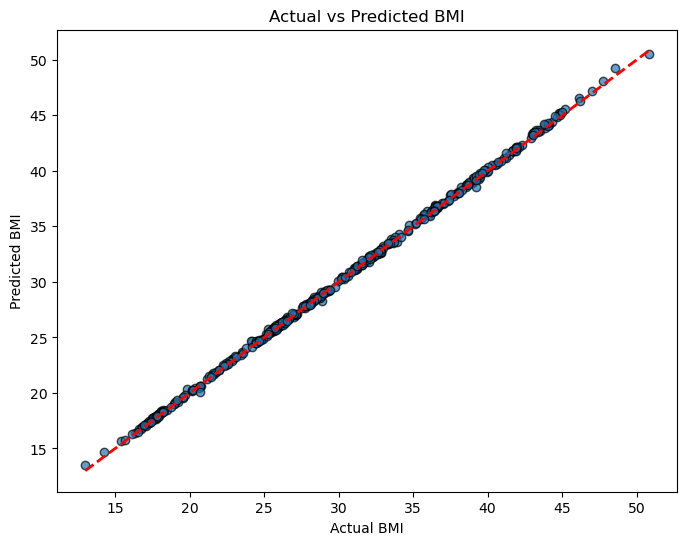

In [11]:
# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Actual vs Predicted BMI')
plt.show()

In [12]:
# 5-fold validation
cross_val_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
cross_val_scores
# 다섯값의 평균 = 최종 accuracy

array([0.99920126, 0.99948577, 0.99973059, 0.99943264, 0.99942858])